In [ ]:
pip install --upgrade pip

In [ ]:
pip install -U langgraph langchain_openai

In [14]:
import os

### Open AI key
os.environ["OPENAI_API_KEY"] = "Your OpenAPI Key"

In [15]:
model_name = "Choose the model"  

In [16]:
from typing import List

from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel

In [17]:
from tempfile import TemporaryDirectory
from langchain_community.agent_toolkits import FileManagementToolkit

file_stores = FileManagementToolkit(
    selected_tools=["read_file", "write_file", "list_directory"], #use current folder
).get_tools()

read_file, write_file, list_file = file_stores

In [18]:
InfoGatherPrompt = """Your job is to apply user-centric approach and gather information \
from the user about the --software or application-- they need to create.

You must obtain the following information from user:
- Personas: who is going to use this application or software, what is their roles and responsibilities.
- Functionalities: what each personas wants to do in the application or software. How they wants to use the app/software.
- Drivers: why do they need this app or software such as cost optimization, performance, availability, \
reliability, operational efficiency, security, etc.
- Constraints: any specific constraints such as time, budget, skills, etc.
- Other: Additionally, user may want to share any other details.

If you are not able to understand this info, ask them to clarify! \
MUST not attempt to wildly guess or assume unless user asked to. 

Whenever the user responds, evaluate if their response is detailed enough to build use cases for each personas. 
If not, ask questions to the user for clarifications.

Always remind them that if they do not know how to answer, then you help them with various options/examples, \
that enables user to answer efficiently.

MUST: Always validate your understanding and only if you understand the Personas, Functionalities,  and Constraints, 
then call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=InfoGatherPrompt)] + messages

class Information(BaseModel):
    """Instructions on how to prompt the LLM."""
    drivers: str
    personas: str
    functionalities: str
    constraints: str
    other: str

llm = ChatOpenAI(model=model_name, temperature=0, max_retries=1)
llm_with_tool = llm.bind_tools([Information])

def information_gathering(state):
    messages = get_messages_info(state["messages"])
    srs = state.get('srs')

    if srs:
        pass #return {"messages": "Proceed further"}
    else:
        response = llm_with_tool.invoke(messages)
        #write_file.invoke({"file_path": "results/srs.md", "text": response.content})
        return {"messages": [response]}

In [19]:
def conclude_conversation(state):
    return {
        "messages": [
            ToolMessage(
                content="Clarified and proceeding further",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

In [20]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# Generate feature list after concluding the conversation
BAPrompt = """
-- Role -- 
You are a Business Analyst. You need to write a reliable requirement document (SRS).

--Task--
As a Business Analyst, you are required to write SRS, based on the information gathered from user, 


-- CRITICAL: Steps MUST be followed --
1. Must go through --Inputs-- 
2. Strictly follow below mentioned --Analysis-- 
2. Create Software Requirement Specification as mentioned in below --Expected Output--


-- Inputs -- 
You will receive following **pre-requisites** or **inputs**, 
1. Clarifications from user, {reqs}

-- Analysis --
1. Understand inputs
2. Write a SRS based inputs
3. Must follow "Expected Output"

-- Expected Output --
{format}

"""

BAReviewPrompt = '''
-- Role -- 
You are a Business Analyst. You need to write a reliable requirement document (SRS).

--Task--
As a Business Analyst, you are required to update SRS to incorporate feedback.

-- CRITICAL: Steps MUST be followed --
1. Must go through --Inputs-- 
2. Strictly follow below mentioned --Analysis-- 
2. Update Software Requirement Specification based on reviews, and follow below mentioned format --Expected Output--

-- Inputs -- 
You will receive following **pre-requisites** or **inputs**, 
1. Software Requirement Specification of current version
2. Review comments from reviewer, {review}

-- Analysis --
1. Understand inputs
2. Update SRS based on provided inputs
3. Must incorporate all review comments
4. Must follow "Expected Output". Must not loose any content while incorporating reviews.

-- Expected Output -- Updated Version of SRS
{format}

'''


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(state):
    tool_call = None
    other_msgs = []
    messages = state["messages"]
    format = state["srs_format"][-1].content
    
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    #return [SystemMessage(content=prompt_system.format(reqs=tool_call, format=format))] + other_msgs

    iteration = state['iteration']
    format = state['srs_format'][-1].content
    last_message = state['messages'][-1].content
    print("***** Revision Number ****", iteration)
        
    srs = state.get('srs')
    if srs:
        srs = state['srs'][-1].content
        return[
            SystemMessage(content=BAReviewPrompt.format(review=last_message, format=format)),
            HumanMessage(content= srs)]
    else:
        return[
            SystemMessage(content=BAPrompt.format(reqs=tool_call, format=format)),
            HumanMessage(content=last_message) ] + other_msgs 


def generate_srs(state):

    messages = get_prompt_messages(state)
    response = llm.invoke(messages)

    iteration = state['iteration']
    file_name = "output/srs v" + str(iteration) + ".md"
    
    write_file.invoke({"file_path": file_name, "text": response.content})
    
    return {
        "messages": [response],
        "srs": [response]
    }

In [21]:
critique = """
--Role-- 
Senior Business Analyst 

--Task--
You are tasked to only review the provided SRS and share the feedback. Also, you are expected to follow below steps.
IMP: Note, you must not make changes in SRS.


-- CRITICAL: Steps MUST be followed --
1. Must go through --Inputs-- 
2. Strictly follow below mentioned --Review-- 

-- Inputs --
1. Software Requirements Specification

--Review--
Analyze provided SRS and Check whether SRS is formal and professional. \
The review comments must be short and concise with clear bullet points. \
Focus on critical comments, no obvious comments.


--Desired Output --
ReqReview = <Say "Satisfied" if there is no review comments, \
            Otherwise Say "Enhance" and list of review comments. Alignment Scope: <in %> >

"""

def get_feedback_info(srs):
    return [SystemMessage(content=critique),
           HumanMessage(content=srs[-1].content)] 

llm = ChatOpenAI(model=model_name, temperature=0, max_retries=1)

def reviewer(state):
    srs = state['srs']
    messages = get_feedback_info(srs )
    response = llm.invoke(messages)
    max_iteration = state['max_iteration']
    iteration = state['iteration'] + 1

    file_name = "output/srs_feedback v" + str(iteration) + ".md"
    
    write_file.invoke({"file_path": file_name, "text": response.content})
    
    return {
        "messages": [response],
        "iteration": iteration
    }

In [22]:
def is_clarified(state):
    messages = state["messages"]
    srs = state.get('srs')
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "yes" #"conclude_conversation"
    else:
        return "no" #"continue_conversation"

In [23]:
def is_reviewed(state):
    max_iteration = state['max_iteration']
    iteration = state['iteration']
    last_message = state['messages'][-1].content
   
    if "satisfied" in last_message.lower():
        return 'reviewed'
    elif iteration > max_iteration:
        return 'reviewed'
    else:
        return 'enhance'

In [28]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END

class State(TypedDict):
    messages: Annotated[list, add_messages]
    srs: Annotated[list, add_messages] #final doc
    srs_format: Annotated[list, add_messages] 
    max_iteration: int
    iteration: int
    
memory = MemorySaver()
workflow = StateGraph(State)

workflow.add_edge(START, "information_gathering")

workflow.add_node("information_gathering", information_gathering)
workflow.add_node("generate_srs", generate_srs)
workflow.add_node("conclude_conversation", conclude_conversation)
workflow.add_node("reviewer",reviewer)

workflow.add_conditional_edges(
    "information_gathering", 
    is_clarified, 
    {"yes": "conclude_conversation",  "no": END}
)

workflow.add_conditional_edges(
    "reviewer", 
    is_reviewed, 
    {"reviewed": END,  "enhance": "generate_srs"}
)

workflow.add_edge("conclude_conversation", "generate_srs")
workflow.add_edge("generate_srs", "reviewer")

graph = workflow.compile(checkpointer=memory)

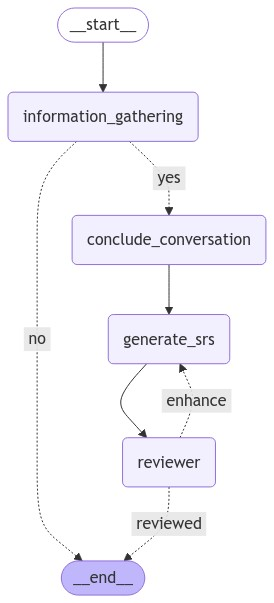

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
thread = {"configurable": {"thread_id": 1}}
FORMAT = read_file.invoke({"file_path": "input/srs_format.md"})
while True:
    user = input("User (q/Q to quit): ")
    if user.lower() in ["quit", "q", "Q"]:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {
            "messages": [HumanMessage(content=user)],
            "srs_format": [HumanMessage(content=FORMAT)],
            "iteration" : 1,
            "max_iteration": 2,
        }, 
        config=thread, 
        stream_mode="updates"):
        #print(output)
        for key, value in output.items():
            print("***** Agent Name: ",key)
            try:
                last_message = next(iter(output.values()))["messages"][-1]
            
                last_message.pretty_print()
            except:
                print("Error while using pretty print")
                #print("***** Result from Agent: ",value)
                print("***** Result from  %s" % (value))
        
    if output and "generate_usecases" in output:
        print("SRS Generated!")

User (q/Q to quit):  build srs for to-do web application for tracking daily task


***** Agent Name:  information_gathering
================================== Ai Message ==================================

To create a Software Requirements Specification (SRS) for your to-do web application, I need to gather some detailed information from you. Let's start with the following:

1. **Personas**: Who will be using this application? What are their roles and responsibilities? For example, are they students, professionals, or managers?

2. **Functionalities**: What do these users want to do in the application? For instance, do they want to add tasks, set deadlines, categorize tasks, or mark them as complete?

3. **Drivers**: Why do they need this application? Are they looking for cost optimization, improved performance, better organization, or something else?

4. **Constraints**: Are there any specific constraints we should consider, such as time, budget, or technical skills?

5. **Other**: Is there any additional information or specific features you would like to include in

User (q/Q to quit):  workder, managers: track and monitor task, improve productivity, 1-month, nothing more


***** Agent Name:  information_gathering
================================== Ai Message ==================================

Thank you for your response! Let's break down the information you've provided and see if we can clarify a few points to ensure we have a comprehensive understanding for the SRS:

1. **Personas**: 
   - You mentioned "workers" and "managers." Can you specify what types of workers (e.g., team members, freelancers) and what roles the managers have (e.g., project managers, team leads)? What are their specific responsibilities in relation to the application?

2. **Functionalities**: 
   - You mentioned tracking and monitoring tasks and improving productivity. Can you elaborate on what specific functionalities you envision? For example:
     - Should users be able to create, edit, and delete tasks?
     - Do they need to set deadlines or priorities for tasks?
     - Should there be a feature for comments or collaboration on tasks?

3. **Drivers**: 
   - You indicated the

User (q/Q to quit):  yes proceed


***** Agent Name:  information_gathering
================================== Ai Message ==================================
Tool Calls:
  Information (call_V6EEN8q5ihKiw3RRLayXmRi6)
 Call ID: call_V6EEN8q5ihKiw3RRLayXmRi6
  Args:
    drivers: Improve productivity
    personas: Workers (team members, freelancers) and Managers (project managers, team leads)
    functionalities: Create, edit, delete tasks; set deadlines and priorities; monitor task progress; possibly add comments or collaborate on tasks.
    constraints: 1-month timeframe, no specific budget mentioned.
***** Agent Name:  conclude_conversation
================================= Tool Message =================================

Clarified and proceeding further
***** Revision Number **** 1
***** Agent Name:  generate_srs
================================== Ai Message ==================================

# Software Requirements Specification (SRS) for Task Management System

## 1. Introduction
This Software Requirements Specificatio

User (q/Q to quit):  q


AI: Byebye
